In [1]:
# read in the module

import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np
import geopandas as gpd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

from scipy import stats
from scipy.special import boxcox1p

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

# libraries for cluster
import matplotlib.pyplot as plt # For plotting
import numpy as np              # For working with numerical data
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score


### Cluster analysis

#### Read in the ULEV data

read in the raw data

In [2]:
ulev_licensed_local_authority_raw = pd.read_excel (r'data.xlsx', sheet_name='ULEV_licensed_veh0132a')

In [3]:
ulev_licensed_local_authority_raw 

,ONS LA Code (Apr-2019),Region/Local Authority,2021 Q2,2021 Q1,2020 Q4,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
0,K02000001,United Kingdom,564694,488079,431661,373225,317268,300016,269376,245138,...,16675,14967,14034,13420,12583,12064,11315,10856,10270,9954
1,K03000001,Great Britain,558022,482403,426777,368977,313554,296466,266194,242121,...,16390,14719,13814,13222,12418,11909,11177,10745,10178,9867
2,E92000001,England,505077,435982,385981,333964,283590,270241,240243,218330,...,14549,13099,12268,11653,11017,10523,10021,9554,9142,9011
3,E12000001,North East,8198,6941,6124,5555,4793,4694,4229,4032,...,524,454,468,445,427,407,390,387,344,349
4,E06000047,County Durham,1619,1344,1224,1113,962,937,813,770,...,87,79,72,57,48,45,43,43,41,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,N09000009,Mid Ulster,244,206,187,171,165,165,144,136,...,12,11,10,9,9,8,7,7,7,7
463,N09000010,"Newry, Mourne and Down",319,272,239,206,180,175,155,155,...,24,19,17,13,7,7,7,6,6,5
464,NaN,Local Authority unknown,344,270,215,146,118,98,86,67,...,c,c,c,c,c,c,0,0,0,0
465,NaN,Vehicle under disposal,7785,6963,6464,5600,5087,2010,4566,4254,...,511,468,467,569,499,540,347,451,371,244


change the column names

In [4]:
ulev_licensed_local_authority_raw.rename(columns={"ONS LA Code (Apr-2019)":"LA_code","Region/Local Authority":"Local_Authority"},inplace=True)

Select specific columns

In [5]:
ulev_licensed_local_authority = ulev_licensed_local_authority_raw[['LA_code','Local_Authority','2019 Q4']]

In [6]:
ulev_licensed_local_authority.shape

(467, 3)

here there are 467 rows

In [7]:
ulev_licensed_local_authority.isna().sum()

LA_code            36
Local_Authority     0
2019 Q4             0
dtype: int64

drop the nas

In [8]:
ulev_licensed_local_authority = ulev_licensed_local_authority.drop(ulev_licensed_local_authority[ulev_licensed_local_authority.LA_code.isna()].index.values, axis=0)

In [9]:
ulev_licensed_local_authority.shape

(431, 3)

Read in the geographic data

In [10]:
local_authority = gpd.read_file('LAD_MAY_2021_UK_BFE_V2.shp')

In [11]:
#region = gpd.read_file('Regions_(December_2017)_Boundaries.shp')

In [12]:
region1 = gpd.read_file('NUTS_Level_1_(January_2018)_Boundaries.shp')

Show the region level and local authority level data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


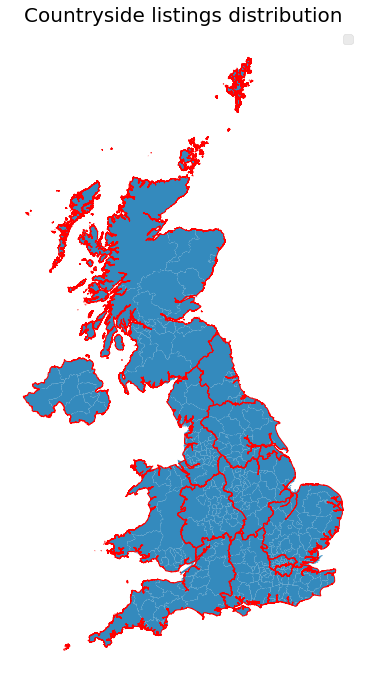

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,12))

local_authority.plot(ax=ax,label='local_authority',legend=True)
region1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1,label='region',legend=True)
ax.set_title('Countryside listings distribution', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title

ax.axis('off')
plt.legend()
ax.legend(fontsize = 13)
plt.show()

#### Read in charging device data

In [14]:
charging_device_local_authority = pd.read_excel (r'data.xlsx', sheet_name='charging_device_Oct19_EVCD_01a')

In [15]:
charging_device_local_authority

,LA / Region Code,Local Authority / Region Name,Total devices,"per 100,000 population"
0,K02000001,UNITED KINGDOM,15116,22.7529
1,K03000001,GREAT BRITAIN,14821,22.9591
2,E92000001,ENGLAND,12549,22.4181
3,E12000001,NORTH EAST,738,27.7662
4,E06000047,County Durham,92,17.4580
...,...,...,...,...
424,N09000006,Fermanagh and Omagh,38,32.5245
425,N09000007,Lisburn and Castlereagh,11,7.6187
426,N09000008,Mid and East Antrim,24,18.7356
427,N09000009,Mid Ulster,23,14.9262


In [16]:
charging_device_local_authority.rename(columns={"LA / Region Code":"LA_code","Local Authority / Region Name":"Local_Authority"},inplace=True)

In [17]:
charging_device_local_authority.shape

(429, 4)

In [18]:
charging_device_local_authority.isna().sum()


LA_code                   0
Local_Authority           0
Total devices             0
per 100,000 population    0
dtype: int64

In [19]:
ulev_licensed_local_authority.isna().sum()

LA_code            0
Local_Authority    0
2019 Q4            0
dtype: int64

#### Merge ULEV data and the charging device data

In [20]:
ulev_cd_df = pd.merge(ulev_licensed_local_authority,charging_device_local_authority,on='LA_code',how='outer')

In [21]:
ulev_cd_df.isna().sum()

LA_code                   0
Local_Authority_x         3
2019 Q4                   3
Local_Authority_y         5
Total devices             5
per 100,000 population    5
dtype: int64

In [22]:
ulev_cd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 0 to 433
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LA_code                 434 non-null    object
 1   Local_Authority_x       431 non-null    object
 2   2019 Q4                 431 non-null    object
 3   Local_Authority_y       429 non-null    object
 4   Total devices           429 non-null    object
 5   per 100,000 population  429 non-null    object
dtypes: object(6)
memory usage: 23.7+ KB


check all the rows containing na

In [23]:
na_rows = ulev_cd_df[ulev_cd_df['Total devices'].isna() | ulev_cd_df['2019 Q4'].isna()]

In [24]:
na_rows 

,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,"per 100,000 population"
267,E10000002,Buckinghamshire,3716,NaN,NaN,NaN
268,E07000004,Aylesbury Vale,925,NaN,NaN,NaN
269,E07000005,Chiltern,674,NaN,NaN,NaN
270,E07000006,South Bucks,584,NaN,NaN,NaN
271,E07000007,Wycombe,1533,NaN,NaN,NaN
431,E06000061,NaN,NaN,North Northamptonshire (from April 2021),-,-
432,E06000062,NaN,NaN,West Northamptonshire (from April 2021),-,-
433,E06000060,NaN,NaN,Buckinghamshire,106,19.6275


drop the nas

In [25]:
ulev_cd_df = ulev_cd_df.drop(na_rows.index.values,axis=0)

In [26]:
ulev_cd_df 

,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,"per 100,000 population"
0,K02000001,United Kingdom,269376,UNITED KINGDOM,15116,22.7529
1,K03000001,Great Britain,266194,GREAT BRITAIN,14821,22.9591
2,E92000001,England,240243,ENGLAND,12549,22.4181
3,E12000001,North East,4229,NORTH EAST,738,27.7662
4,E06000047,County Durham,813,County Durham,92,17.4580
...,...,...,...,...,...,...
426,N09000006,Fermanagh and Omagh,82,Fermanagh and Omagh,38,32.5245
427,N09000007,Lisburn and Castlereagh,273,Lisburn and Castlereagh,11,7.6187
428,N09000008,Mid and East Antrim,164,Mid and East Antrim,24,18.7356
429,N09000009,Mid Ulster,144,Mid Ulster,23,14.9262


#### cluster analysis (k means)

merge the ulev_cd_df with the local_authority data

In [27]:
ulev_cd_df_local_authority = pd.merge(ulev_cd_df,local_authority,how='outer',left_on='LA_code', right_on='LAD21CD')

In [28]:
ulev_cd_df_local_authority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 0 to 428
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LA_code                 426 non-null    object  
 1   Local_Authority_x       426 non-null    object  
 2   2019 Q4                 426 non-null    object  
 3   Local_Authority_y       426 non-null    object  
 4   Total devices           426 non-null    object  
 5   per 100,000 population  426 non-null    object  
 6   OBJECTID                374 non-null    float64 
 7   LAD21CD                 374 non-null    object  
 8   LAD21NM                 374 non-null    object  
 9   BNG_E                   374 non-null    float64 
 10  BNG_N                   374 non-null    float64 
 11  LONG                    374 non-null    float64 
 12  LAT                     374 non-null    float64 
 13  SHAPE_Leng              374 non-null    float64 
 14  SHAPE_Area              37

Check NAs

In [29]:
ulev_cd_df_local_authority_nas = ulev_cd_df_local_authority[ulev_cd_df_local_authority['OBJECTID'].isna() | ulev_cd_df_local_authority['2019 Q4'].isna()]

In [30]:
ulev_cd_df_local_authority_nas

,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,"per 100,000 population",OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry
0,K02000001,United Kingdom,269376,UNITED KINGDOM,15116,22.7529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,K03000001,Great Britain,266194,GREAT BRITAIN,14821,22.9591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,E92000001,England,240243,ENGLAND,12549,22.4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,E12000001,North East,4229,NORTH EAST,738,27.7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
11,E11000007,Tyne and Wear (Met County),1787,Tyne and Wear (Met County),362,31.8558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
17,E12000002,North West,13979,NORTH WEST,1204,16.5110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
24,E10000006,Cumbria,840,Cumbria,150,30.0669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
31,E11000001,Greater Manchester (Met County),4740,Greater Manchester (Met County),446,15.8574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
42,E10000017,Lancashire,2544,Lancashire,239,19.7512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
55,E11000002,Merseyside (Met County),1926,Merseyside (Met County),169,11.8758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [31]:
ulev_cd_df_local_authority = ulev_cd_df_local_authority.drop(ulev_cd_df_local_authority_nas.index.values,axis=0)

In [32]:
ulev_cd_df_local_authority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 4 to 425
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LA_code                 371 non-null    object  
 1   Local_Authority_x       371 non-null    object  
 2   2019 Q4                 371 non-null    object  
 3   Local_Authority_y       371 non-null    object  
 4   Total devices           371 non-null    object  
 5   per 100,000 population  371 non-null    object  
 6   OBJECTID                371 non-null    float64 
 7   LAD21CD                 371 non-null    object  
 8   LAD21NM                 371 non-null    object  
 9   BNG_E                   371 non-null    float64 
 10  BNG_N                   371 non-null    float64 
 11  LONG                    371 non-null    float64 
 12  LAT                     371 non-null    float64 
 13  SHAPE_Leng              371 non-null    float64 
 14  SHAPE_Area              37

Change the data type

In [33]:
ulev_cd_df_local_authority["Total devices"] = ulev_cd_df_local_authority["Total devices"].astype('int')
ulev_cd_df_local_authority["per 100,000 population"] = ulev_cd_df_local_authority["per 100,000 population"].astype('float')
ulev_cd_df_local_authority["2019 Q4"] = ulev_cd_df_local_authority["2019 Q4"].astype('int')

In [34]:
ulev_cd_df_local_authority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 4 to 425
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LA_code                 371 non-null    object  
 1   Local_Authority_x       371 non-null    object  
 2   2019 Q4                 371 non-null    int32   
 3   Local_Authority_y       371 non-null    object  
 4   Total devices           371 non-null    int32   
 5   per 100,000 population  371 non-null    float64 
 6   OBJECTID                371 non-null    float64 
 7   LAD21CD                 371 non-null    object  
 8   LAD21NM                 371 non-null    object  
 9   BNG_E                   371 non-null    float64 
 10  BNG_N                   371 non-null    float64 
 11  LONG                    371 non-null    float64 
 12  LAT                     371 non-null    float64 
 13  SHAPE_Leng              371 non-null    float64 
 14  SHAPE_Area              37

In [35]:
ulev_cd_df_local_authority1 = ulev_cd_df_local_authority

In [36]:
# convert df to gdf
ulev_cd_local_authority1_gdf = gpd.GeoDataFrame(ulev_cd_df_local_authority1, geometry=ulev_cd_df_local_authority1.geometry,crs='epsg:27700')


In [37]:
ulev_cd_df_local_authority1.shape

(371, 16)

<AxesSubplot:>

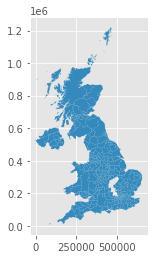

In [38]:
ulev_cd_local_authority1_gdf.plot()

Show the gdf data (there are some NAs so the map is not complete)

<AxesSubplot:>

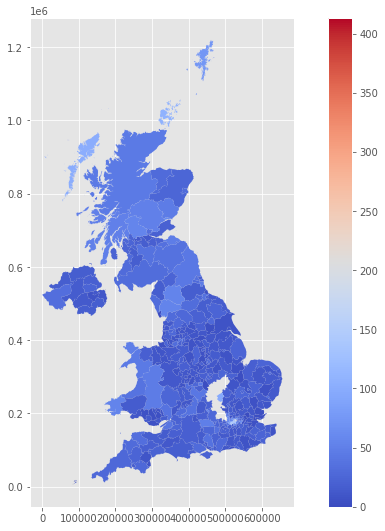

In [39]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ulev_cd_local_authority1_gdf.plot(ax=ax,column='per 100,000 population',cmap='coolwarm',legend=True)
#region1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1,label='region',legend=True)
#ax.set_title('Countryside listings distribution', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title

#ax.axis('off')
#local_authority.plot(ax=ax,label='local_authority',edgecolor='black',facecolor='none',legend=True)
#region1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.5,label='region',legend=True)

In [40]:
data_cluster = ulev_cd_local_authority1_gdf

In [41]:
data_cluster['population_100000'] = data_cluster['Total devices']/data_cluster['per 100,000 population']

In [42]:
data_cluster['ULEV_per_100000_population'] = data_cluster['2019 Q4']/data_cluster['population_100000']

In [43]:
data_cluster = data_cluster.rename(columns={'per 100,000 population':'charging_devices_per_100000_population'})

In [44]:
data_cluster[data_cluster['charging_devices_per_100000_population']==0]

,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,charging_devices_per_100000_population,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,population_100000,ULEV_per_100000_population
26,E07000027,Barrow-in-Furness,68,Barrow-in-Furness,0,0.0000,66.0000,E07000027,Barrow-in-Furness,"321,741.0000","474,165.0000",-3.1999,54.1573,"80,046.5737","132,075,297.8576","POLYGON ((324878.102 479233.100, 324864.399 47...",NaN,NaN
330,E06000053,Isles of Scilly,57,Isles of Scilly,0,0.0000,50.0000,E06000053,Isles of Scilly,"91,327.0000","11,447.0000",-6.3022,49.9233,"180,298.5043","22,851,430.2501","MULTIPOLYGON (((84014.170 5445.450, 84021.580 ...",NaN,NaN


check the distribution of data(need to contain all 3 columns)

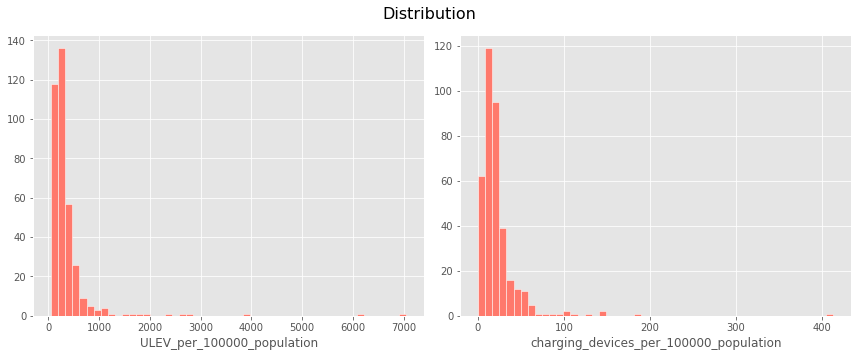

In [45]:
fig1, axes1 = plt.subplots(1,2,figsize=(12,5))
axes1[0].hist(data_cluster['ULEV_per_100000_population'],bins=50,color='xkcd:salmon',edgecolor="white")
axes1[0].set(xlabel='ULEV_per_100000_population')
axes1[1].hist(data_cluster['charging_devices_per_100000_population'],bins=50,color='xkcd:salmon',edgecolor="white")
axes1[1].set(xlabel='charging_devices_per_100000_population')
fig1.suptitle('Distribution',fontsize=16)
fig1.tight_layout(pad=1)

In [46]:
cols_cluster = ['ULEV_per_100000_population','charging_devices_per_100000_population']

Scale the two columns to normalise them

In [47]:
from sklearn.preprocessing import MinMaxScaler

scalers = [MinMaxScaler().fit(data_cluster[x].values.reshape(-1,1)) for x in cols_cluster]

In [48]:
scalers 

[MinMaxScaler(), MinMaxScaler()]

In [49]:
data_cluster_normalised = data_cluster[cols_cluster+['LA_code','Local_Authority_x','geometry']].copy()

for i in range(0, len(cols_cluster)):
    # Ditto this -- can you explain what this code is doing
    data_cluster_normalised[cols_cluster[i]] = scalers[i].transform(data_cluster_normalised[cols_cluster[i]].values.reshape(-1,1))

In [50]:
data_cluster_normalised[data_cluster_normalised['ULEV_per_100000_population'].isna()]

,ULEV_per_100000_population,charging_devices_per_100000_population,LA_code,Local_Authority_x,geometry
26,NaN,0.0000,E07000027,Barrow-in-Furness,"POLYGON ((324878.102 479233.100, 324864.399 47..."
330,NaN,0.0000,E06000053,Isles of Scilly,"MULTIPOLYGON (((84014.170 5445.450, 84021.580 ..."


In [51]:
 data_cluster_normalised = data_cluster_normalised.drop(26)

In [52]:
data_cluster_normalised = data_cluster_normalised.drop(330)

Here do the distribution plot for the data after normalisation

(array([118., 136.,  57.,  26.,   9.,   5.,   3.,   4.,   1.,   0.,   1.,
          1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

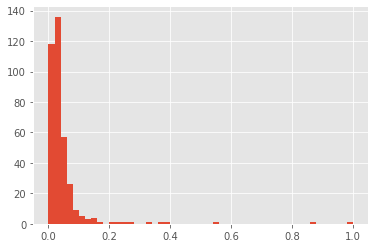

In [53]:
plt.hist(data_cluster_normalised['ULEV_per_100000_population'],bins=50)

(array([ 87., 106.,  89.,  32.,  15.,  13.,  10.,   5.,   1.,   1.,   1.,
          1.,   3.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00268495, 0.02263125, 0.04257755, 0.06252385, 0.08247015,
        0.10241645, 0.12236275, 0.14230906, 0.16225536, 0.18220166,
        0.20214796, 0.22209426, 0.24204056, 0.26198686, 0.28193316,
        0.30187946, 0.32182577, 0.34177207, 0.36171837, 0.38166467,
        0.40161097, 0.42155727, 0.44150357, 0.46144987, 0.48139617,
        0.50134247, 0.52128878, 0.54123508, 0.56118138, 0.58112768,
        0.60107398, 0.62102028, 0.64096658, 0.66091288, 0.68085918,
        0.70080548, 0.72075179, 0.74069809, 0.76064439, 0.78059069,
        0.80053699, 0.82048329, 0.84042959, 0.86037589, 0.88032219,
        0.90026849, 0.9202148 , 0.9401611 , 0.

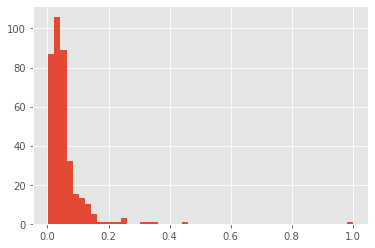

In [54]:
plt.hist(data_cluster_normalised['charging_devices_per_100000_population'],bins=50)

Do the K means cluster

In [55]:
kmeans_data = data_cluster_normalised[['charging_devices_per_100000_population','ULEV_per_100000_population','LA_code']].set_index('LA_code')

In [56]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [57]:
c_nm   = 'KMeans' # Clustering name
k_pref = 5 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(kmeans_data) # The process

print(kmeans.labels_) # The results

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 2 0 2
 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 1 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 1 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [58]:
len(kmeans.labels_)

369

In [59]:
Kmeansdata_with_clusters = np.hstack((kmeans_data,np.array([kmeans.labels_]).T))

In [60]:
Kmeansdata_with_clusters

array([[0.04221919, 0.01405715, 0.        ],
       [0.06127189, 0.02379565, 0.        ],
       [0.01296805, 0.00718095, 0.        ],
       ...,
       [0.04530901, 0.01030476, 0.        ],
       [0.03609649, 0.0053619 , 0.        ],
       [0.04030287, 0.00391474, 0.        ]])

In [61]:
data_by_cluster = []

for i in range(k_pref):
    
    this_data = []
    
    for row in Kmeansdata_with_clusters:
        
        if row[-1] == i:
            this_data.append(row)
    
    this_data = np.array(this_data)
    
    data_by_cluster.append(this_data)
    
#Which gives the following:
data_by_cluster

[array([[0.04221919, 0.01405715, 0.        ],
        [0.06127189, 0.02379565, 0.        ],
        [0.01296805, 0.00718095, 0.        ],
        ...,
        [0.04530901, 0.01030476, 0.        ],
        [0.03609649, 0.0053619 , 0.        ],
        [0.04030287, 0.00391474, 0.        ]]),
 array([[0.01906912, 0.26187765, 1.        ],
        [0.07497391, 0.24536417, 1.        ],
        [0.2322836 , 0.37487765, 1.        ],
        [0.02505526, 0.39737535, 1.        ],
        [0.02514935, 0.55429421, 1.        ],
        [0.0571292 , 0.22779276, 1.        ],
        [0.13587583, 0.20578042, 1.        ]]),
 array([[0.3573519 , 0.12121586, 2.        ],
        [0.1850595 , 0.05865601, 2.        ],
        [0.25236614, 0.12855516, 2.        ],
        [0.30666761, 0.05536378, 2.        ],
        [0.45937384, 0.15538205, 2.        ],
        [0.20273196, 0.06147935, 2.        ],
        [0.34143373, 0.0798511 , 2.        ],
        [0.24336564, 0.0131023 , 2.        ],
        [0.261559

In [62]:
# FIGURE PARAMETERS

# Use the next line to set figure height and width (experiment to check the scale):
figure_width, figure_height = 7,7

# These lines set the figure title and axis labels and the font sizes:
fig_title = 'Figure Title'
x_label   = 'ULEV amounts per 100000 population'
y_label   = 'Charging device amounts per 100000 population'
title_fontsize = 18
label_fontsize = 16

#x_min, x_max = 0.5*np.min(data_use_array[:,0]), 1.1*np.max(data_use_array[:,0])
#y_min, y_max = 0.5*np.min(data_use_array[:,1]), 1.1*np.max(data_use_array[:,1])
# This is a function that sets up each figure's x-limits and y-limits and axis labels.

def setup_figure():
    
   # plt.xlim([x_min, x_max])
   # plt.ylim([y_min, y_max])
    plt.xlabel(x_label,fontsize=label_fontsize)
    plt.ylabel(y_label,fontsize=label_fontsize)


In [63]:
data_by_cluster

[array([[0.04221919, 0.01405715, 0.        ],
        [0.06127189, 0.02379565, 0.        ],
        [0.01296805, 0.00718095, 0.        ],
        ...,
        [0.04530901, 0.01030476, 0.        ],
        [0.03609649, 0.0053619 , 0.        ],
        [0.04030287, 0.00391474, 0.        ]]),
 array([[0.01906912, 0.26187765, 1.        ],
        [0.07497391, 0.24536417, 1.        ],
        [0.2322836 , 0.37487765, 1.        ],
        [0.02505526, 0.39737535, 1.        ],
        [0.02514935, 0.55429421, 1.        ],
        [0.0571292 , 0.22779276, 1.        ],
        [0.13587583, 0.20578042, 1.        ]]),
 array([[0.3573519 , 0.12121586, 2.        ],
        [0.1850595 , 0.05865601, 2.        ],
        [0.25236614, 0.12855516, 2.        ],
        [0.30666761, 0.05536378, 2.        ],
        [0.45937384, 0.15538205, 2.        ],
        [0.20273196, 0.06147935, 2.        ],
        [0.34143373, 0.0798511 , 2.        ],
        [0.24336564, 0.0131023 , 2.        ],
        [0.261559

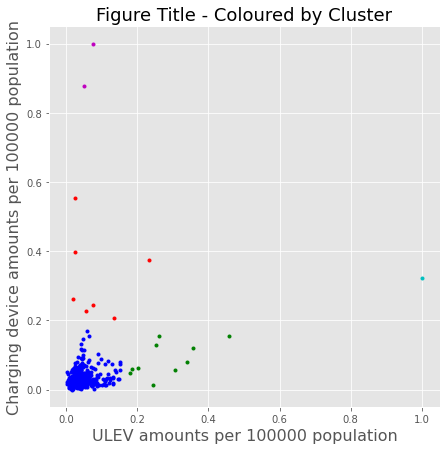

In [64]:
# This is a list of colours to differentiate each cluster.
color_list = ['b','r','g','m','c','k','y']
#Might be nice to have those on the same plot though.
# FIGURE N + 1 : COMBINED CLUSTER PLOT

# These lines create a plot with all the data points, coloured by cluster.
plt.figure(k_pref + 1,figsize=(figure_width,figure_height))
setup_figure()
plt.title(fig_title + ' - Coloured by Cluster',fontsize=title_fontsize)

for i in range(k_pref):
    
    x_values = data_by_cluster[i][:,0]
    y_values = data_by_cluster[i][:,1]
    
    plt.plot(x_values,y_values,color_list[i % 5] + '.')
    

SILHOUETTE score plot

In [65]:
# calculate the SILHOUETTE SCORE of the cluster above (cluster number ==5)
import sklearn.metrics as sklm  # For the silhouette score
# These lines calculate the silhouette score...
silhouette_kmeans = sklm.silhouette_score(kmeans_data,kmeans.labels_)

# ... and print it:
print("Silhouette Score:", silhouette_kmeans)

Silhouette Score: 0.7733845802240836


In [66]:
# cluster_numbers = range(1,10)
# a = list(cluster_numbers)

In [67]:
all_scores = {'n':[],'ss':[]}
for n in range(2,10):
    # This line performs the k-means clustering:
    kmeans1 = sklc.KMeans(n_clusters=n, n_init=10,random_state=42)
    
    kmeans1_output = kmeans1.fit(kmeans_data)
    
    # This line creates a list giving the final cluster number of each point:
    clustering_ids_kmeans = kmeans1_output.labels_
    
    ss = sklm.silhouette_score(kmeans_data,clustering_ids_kmeans)
    
    all_scores['n'].append(n)
    all_scores['ss'].append(ss)
    

In [68]:
Kmeans_result_df = pd.DataFrame(all_scores)

Text(0, 0.5, 'Silhouette Score')

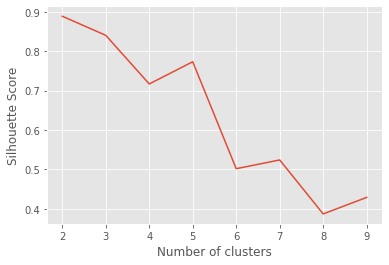

In [69]:
plt.plot(Kmeans_result_df.n,Kmeans_result_df.ss)

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")

From the plot above can see cluster number of 5 is the best


In [70]:
kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, E06000047 to N09000010
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   charging_devices_per_100000_population  369 non-null    float64
 1   ULEV_per_100000_population              369 non-null    float64
dtypes: float64(2)
memory usage: 8.6+ KB


In [71]:
cluster_df = pd.DataFrame(kmeans.labels_, index=kmeans_data.index)

In [72]:
cluster_df

,0
LA_code,
E06000047,0
E06000005,0
E06000001,0
E06000002,0
E06000057,0
...,...
N09000006,0
N09000007,0
N09000008,0


In [73]:
# add back
ulev_cd_local_authority1_gdf_cluster = pd.merge(ulev_cd_local_authority1_gdf,cluster_df,on='LA_code',how='outer')

In [74]:
ulev_cd_local_authority1_gdf_cluster.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 371 entries, 0 to 370
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LA_code                     371 non-null    object  
 1   Local_Authority_x           371 non-null    object  
 2   2019 Q4                     371 non-null    int32   
 3   Local_Authority_y           371 non-null    object  
 4   Total devices               371 non-null    int32   
 5   per 100,000 population      371 non-null    float64 
 6   OBJECTID                    371 non-null    float64 
 7   LAD21CD                     371 non-null    object  
 8   LAD21NM                     371 non-null    object  
 9   BNG_E                       371 non-null    float64 
 10  BNG_N                       371 non-null    float64 
 11  LONG                        371 non-null    float64 
 12  LAT                         371 non-null    float64 
 13  SHAPE_Leng  

check and drop NAs

In [75]:
ulev_cd_local_authority1_gdf_cluster[ulev_cd_local_authority1_gdf_cluster[0].isna()]


,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,"per 100,000 population",OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,population_100000,ULEV_per_100000_population,0
19,E07000027,Barrow-in-Furness,68,Barrow-in-Furness,0,0.0000,66.0000,E07000027,Barrow-in-Furness,"321,741.0000","474,165.0000",-3.1999,54.1573,"80,046.5737","132,075,297.8576","POLYGON ((324878.102 479233.100, 324864.399 47...",NaN,NaN,NaN
281,E06000053,Isles of Scilly,57,Isles of Scilly,0,0.0000,50.0000,E06000053,Isles of Scilly,"91,327.0000","11,447.0000",-6.3022,49.9233,"180,298.5043","22,851,430.2501","MULTIPOLYGON (((84014.170 5445.450, 84021.580 ...",NaN,NaN,NaN


In [76]:
ulev_cd_local_authority1_gdf_cluster =ulev_cd_local_authority1_gdf_cluster.drop(index=19)

In [77]:
ulev_cd_local_authority1_gdf_cluster =ulev_cd_local_authority1_gdf_cluster.drop(index=281)

In [78]:
ulev_cd_local_authority1_gdf_cluster.shape

(369, 19)

In [79]:
ulev_cd_local_authority1_gdf_cluster.head(1)

,LA_code,Local_Authority_x,2019 Q4,Local_Authority_y,Total devices,"per 100,000 population",OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,population_100000,ULEV_per_100000_population,0
0,E06000047,County Durham,813,County Durham,92,17.4580,45.0000,E06000047,County Durham,"410,381.0000","532,242.0000",-1.8405,54.6851,"310,045.7205","2,232,609,136.8672","POLYGON ((416954.896 558226.799, 416959.398 55...",5.2698,154.2753,0.0000


Rename columns

In [80]:
ulev_cd_local_authority1_gdf_cluster = ulev_cd_local_authority1_gdf_cluster.rename(columns={0:'cluster','per 100,000 population':'charging_devices_per_100000_population'})

In [81]:
cluster_group = ulev_cd_local_authority1_gdf_cluster.groupby(['cluster'])['ULEV_per_100000_population','charging_devices_per_100000_population'].agg(['mean', 'count'])#agg(median_price='median').reset_index() # msoa listings grouped price
cluster_group

<ipython-input-81-342b3780f804>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_group = ulev_cd_local_authority1_gdf_cluster.groupby(['cluster'])['ULEV_per_100000_population','charging_devices_per_100000_population'].agg(['mean', 'count'])#agg(median_price='median').reset_index() # msoa listings grouped price


ULEV_per_100000_population        \
                                            mean count   
cluster                                                  
0.0000                                  288.7189   349   
1.0000                                2,321.7291     7   
2.0000                                  669.8967    10   
3.0000                                6,623.1647     2   
4.0000                                2,320.2389     1   

          charging_devices_per_100000_population        
                                            mean count  
cluster                                                 
0.0000                                   19.1411   349  
1.0000                                   33.6440     7  
2.0000                                  115.3163    10  
3.0000                                   26.2056     2  
4.0000                                  413.5079     1

Map 

(-32921.45225500032, 688794.2557549998, -49277.15554000084, 1280766.4063399995)

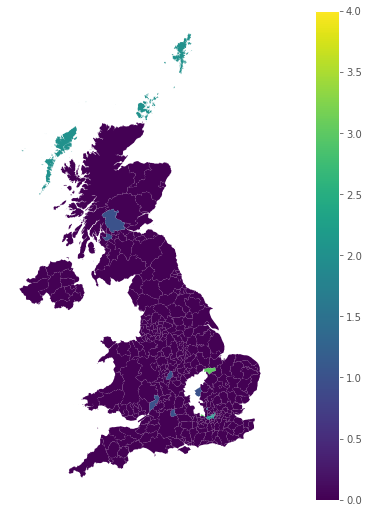

In [82]:
fig, ax = plt.subplots(1,1, figsize=(15,9))

ulev_cd_local_authority1_gdf_cluster.plot(ax=ax,column='cluster',legend=True)
#region1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1,label='region',legend=True)
#ax.set_title('Countryside listings distribution', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title

ax.axis('off')
#local_authority.plot(ax=ax,label='local_authority',edgecolor='black',facecolor='none',legend=True)
#region1.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1,label='region',legend=True)

### Linear regression


#### read in earning data

In [83]:

earning = pd.read_excel (r'data.xlsx', sheet_name='earning')

In [84]:
#earning = earning.rename(columns={'Unnamed: 0':'region'})

In [85]:
earning

,Region,2017,2018,2019,2020,2021p
0,United Kingdom,28759,29559,30378,31487,31285
1,England,29083,29856,30704,31791,31480
2,North East,25904,26355,27234,27833,27515
3,North West,26754,27376,28175,29459,29529
4,Yorkshire and The Humber,26309,26892,27879,28709,28808
5,East Midlands,25882,26711,28044,29043,28416
6,West Midlands,26837,27682,28549,29628,30000
7,East,28456,29153,30350,31016,30867
8,London,37171,38146,39013,40994,39716
9,South East,30236,30849,32127,32980,32810


In [86]:
earning = earning.drop(index=[0,1,13])

In [87]:
earning = earning.rename(columns={'Region':'region'})

In [88]:
earning.region[7]='East of England'

<ipython-input-88-14c6c71a6e0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earning.region[7]='East of England'


In [89]:
earning = earning[['region',2019]]

In [90]:
earning = earning.rename(columns={2019:'earning_2019'})

In [91]:
earning

,region,earning_2019
2,North East,27234
3,North West,28175
4,Yorkshire and The Humber,27879
5,East Midlands,28044
6,West Midlands,28549
7,East of England,30350
8,London,39013
9,South East,32127
10,South West,28721
11,Wales,27466


#### read in median house price data

In [92]:
cols_house_price = []
for i in range(0,6):
    cols_house_price.append(i)
print(cols_house_price)

[0, 1, 2, 3, 4, 5]


In [93]:

median_house_price = pd.read_excel (r'data.xlsx', sheet_name='median_house_price',skiprows=4,usecols=cols_house_price)

In [94]:
median_house_price['mean_median_house_price_2019'] = median_house_price.mean(axis=1)

<ipython-input-94-198a08b9ad8f>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_house_price['mean_median_house_price_2019'] = median_house_price.mean(axis=1)


In [95]:
median_house_price = median_house_price[['Code','Name','mean_median_house_price_2019']].drop(index=[0,1])

In [96]:
median_house_price = median_house_price.rename(columns={'Name':'region'})

In [97]:
median_house_price.region.values

array(['North East', 'North West', 'Yorkshire and The Humber',
       'East Midlands', 'West Midlands', 'East of England', 'London',
       'South East', 'South West', 'Wales', 'Scotland'], dtype=object)

#### read in carbon_emission data

In [98]:
cols_carbon_emission = [0,29]


In [99]:
carbon_emission = pd.read_excel (r'data.xlsx', sheet_name='carbon_emission_direct_scope',skiprows=1,usecols=cols_carbon_emission)

In [100]:
carbon_emission

,Region/Country,Per Capita Emissions (t)
0,North East Total,4.4912
1,North West Total,4.1238
2,Yorkshire and the Humber Total,4.4510
3,East Midlands Total,4.6993
4,West Midlands Total,4.1796
5,East of England Total,4.4398
6,London Total,3.1111
7,South East Total,3.9379
8,South West Total,4.2512
9,Wales Total,4.9088


In [101]:
carbon_emission = carbon_emission.rename(columns={'Region/Country':'region','Per Capita Emissions (t)':'emissions_per_person_t_2019'})

In [102]:
carbon_emission = carbon_emission.drop(index=11)

In [103]:
carbon_emission['region'] = carbon_emission['region'].str.replace(' Total','')

In [104]:
carbon_emission.region[2] = 'Yorkshire and The Humber'

<ipython-input-104-accd63801d31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_emission.region[2] = 'Yorkshire and The Humber'


In [105]:
carbon_emission

,region,emissions_per_person_t_2019
0,North East,4.4912
1,North West,4.1238
2,Yorkshire and The Humber,4.4510
3,East Midlands,4.6993
4,West Midlands,4.1796
5,East of England,4.4398
6,London,3.1111
7,South East,3.9379
8,South West,4.2512
9,Wales,4.9088


#### read in education level data

In [106]:
education = pd.read_excel (r'data.xlsx', sheet_name='education_level_2019end') 

In [107]:
education = education.drop(index=[0,2,13])

In [108]:
education

,region,Unnamed: 1,Unnamed: 2,No qualifications,Qualified to NQF level 2 or above,Qualified to NQF level 3 or above,Qualified to NQF level 4 or above
1,Wales,NaN,NaN,8.2000,79.1000,59.4000,38.8000
3,North East,NaN,NaN,9.1000,78.3000,56.0000,34.2000
4,North West,NaN,NaN,8.3000,79.4000,59.2000,38.6000
5,Yorkshire & Humberside,NaN,NaN,8.0000,78.4000,58.9000,36.8000
6,East Midlands,NaN,NaN,7.0000,79.3000,60.0000,36.0000
7,West Midlands,NaN,NaN,9.8000,77.7000,57.6000,36.8000
8,East,NaN,NaN,6.8000,78.4000,58.6000,39.1000
9,London,NaN,NaN,6.2000,83.8000,71.3000,57.3000
10,South East,NaN,NaN,5.3000,83.2000,66.2000,46.0000
11,South West,NaN,NaN,4.8000,82.6000,64.3000,41.5000


In [109]:
education = education.drop(columns=['Unnamed: 1','Unnamed: 2'])

In [110]:
education['region'][5]='Yorkshire and The Humber'

<ipython-input-110-d53f8be25845>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education['region'][5]='Yorkshire and The Humber'


In [111]:
education['region'][8]='East of England'

<ipython-input-111-51d78a9fa3b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education['region'][8]='East of England'


In [112]:
education.region.values

array(['Wales', 'North East', 'North West', 'Yorkshire and The Humber',
       'East Midlands', 'West Midlands', 'East of England', 'London',
       'South East', 'South West', 'Scotland'], dtype=object)

#### read in rapid charging devices data

In [113]:
rapid_charging = pd.read_excel (r'data.xlsx', sheet_name='rapid_charging_region') 

In [114]:
rapid_charging = rapid_charging.rename(columns={'per 100,000 population':'rapid_charging_100000_pop','Name':'region'})

#### read in total charging devices data

In [115]:
total_charging = pd.read_excel (r'data.xlsx', sheet_name='charging_device_region') 

In [116]:
total_charging = total_charging[['region','charging_per_100000_pop']]

In [117]:
total_charging

,region,charging_per_100000_pop
0,North East,31.7985
1,North West,19.1113
2,Yorkshire and The Humber,18.0993
3,East Midlands,21.2782
4,West Midlands,19.2281
5,East of England,19.7079
6,London,63.0998
7,South East,28.8558
8,South West,26.7570
9,Wales,21.4090


#### cars_registered

In [118]:
cars_registered_row = pd.read_excel (r'data.xlsx', sheet_name='Car_new_regis_veh0254',skiprows=3) 

In [119]:
cars_registered_row

,Year,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland,Between Keepers: previously GB 1,Great Britain,Northern Ireland,Between Keepers: previously NI 2,United Kingdom
0,Thousands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,93.9480,308.3990,184.6790,213.2180,325.0890,271.3160,258.6840,427.4330,197.5510,95.5730,205.8280,4.2610,"2,585.9820",NaN,NaN,NaN
2,2002,94.3880,323.2300,203.2460,224.1060,333.6280,276.5490,246.7720,457.3940,198.2050,100.1960,220.5120,3.9020,"2,682.1310",NaN,NaN,NaN
3,2003,98.4790,322.4660,211.6130,219.2210,339.0170,265.3780,228.6240,447.1740,190.6450,100.1980,219.3320,3.9090,"2,646.0560",NaN,NaN,NaN
4,2004,96.6450,329.7830,201.2690,213.5360,341.8510,255.5700,216.4080,430.0610,190.4930,102.2260,217.8610,3.3760,"2,599.0790",NaN,NaN,NaN
5,2005,82.0260,329.9000,192.6680,208.9740,321.8490,231.2450,192.6500,402.3240,181.1380,93.3480,203.1670,4.1660,"2,443.4550",NaN,NaN,NaN
6,2006,80.5470,316.8290,179.3640,202.8080,288.9100,219.6520,193.5930,390.6670,178.7230,90.6360,196.5180,1.7960,"2,340.0430",NaN,NaN,NaN
7,2007,78.8830,307.8840,187.6470,204.7340,302.9200,216.9490,198.3490,403.0140,194.1580,91.3370,202.5440,1.6610,"2,390.0800",NaN,NaN,NaN
8,2008,68.6050,259.6090,169.1080,206.5410,270.2310,173.7140,167.3850,374.3610,167.5640,80.7640,172.6680,1.4480,"2,111.9980",NaN,NaN,NaN
9,2009,67.3580,234.2030,155.4280,178.0900,239.1150,175.8170,134.5250,358.5470,160.1950,78.3680,186.2120,0.3940,"1,968.2520",NaN,NaN,NaN


In [120]:
cars_registered_row = cars_registered_row.iloc[0:21]

In [121]:
cars_registered_row

,Year,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland,Between Keepers: previously GB 1,Great Britain,Northern Ireland,Between Keepers: previously NI 2,United Kingdom
0,Thousands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,93.9480,308.3990,184.6790,213.2180,325.0890,271.3160,258.6840,427.4330,197.5510,95.5730,205.8280,4.2610,"2,585.9820",NaN,NaN,NaN
2,2002,94.3880,323.2300,203.2460,224.1060,333.6280,276.5490,246.7720,457.3940,198.2050,100.1960,220.5120,3.9020,"2,682.1310",NaN,NaN,NaN
3,2003,98.4790,322.4660,211.6130,219.2210,339.0170,265.3780,228.6240,447.1740,190.6450,100.1980,219.3320,3.9090,"2,646.0560",NaN,NaN,NaN
4,2004,96.6450,329.7830,201.2690,213.5360,341.8510,255.5700,216.4080,430.0610,190.4930,102.2260,217.8610,3.3760,"2,599.0790",NaN,NaN,NaN
5,2005,82.0260,329.9000,192.6680,208.9740,321.8490,231.2450,192.6500,402.3240,181.1380,93.3480,203.1670,4.1660,"2,443.4550",NaN,NaN,NaN
6,2006,80.5470,316.8290,179.3640,202.8080,288.9100,219.6520,193.5930,390.6670,178.7230,90.6360,196.5180,1.7960,"2,340.0430",NaN,NaN,NaN
7,2007,78.8830,307.8840,187.6470,204.7340,302.9200,216.9490,198.3490,403.0140,194.1580,91.3370,202.5440,1.6610,"2,390.0800",NaN,NaN,NaN
8,2008,68.6050,259.6090,169.1080,206.5410,270.2310,173.7140,167.3850,374.3610,167.5640,80.7640,172.6680,1.4480,"2,111.9980",NaN,NaN,NaN
9,2009,67.3580,234.2030,155.4280,178.0900,239.1150,175.8170,134.5250,358.5470,160.1950,78.3680,186.2120,0.3940,"1,968.2520",NaN,NaN,NaN


In [122]:
cars_registered_row = cars_registered_row.drop(index=0)

In [123]:
cars_registered_row

,Year,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland,Between Keepers: previously GB 1,Great Britain,Northern Ireland,Between Keepers: previously NI 2,United Kingdom
1,2001,93.9480,308.3990,184.6790,213.2180,325.0890,271.3160,258.6840,427.4330,197.5510,95.5730,205.8280,4.2610,"2,585.9820",NaN,NaN,NaN
2,2002,94.3880,323.2300,203.2460,224.1060,333.6280,276.5490,246.7720,457.3940,198.2050,100.1960,220.5120,3.9020,"2,682.1310",NaN,NaN,NaN
3,2003,98.4790,322.4660,211.6130,219.2210,339.0170,265.3780,228.6240,447.1740,190.6450,100.1980,219.3320,3.9090,"2,646.0560",NaN,NaN,NaN
4,2004,96.6450,329.7830,201.2690,213.5360,341.8510,255.5700,216.4080,430.0610,190.4930,102.2260,217.8610,3.3760,"2,599.0790",NaN,NaN,NaN
5,2005,82.0260,329.9000,192.6680,208.9740,321.8490,231.2450,192.6500,402.3240,181.1380,93.3480,203.1670,4.1660,"2,443.4550",NaN,NaN,NaN
6,2006,80.5470,316.8290,179.3640,202.8080,288.9100,219.6520,193.5930,390.6670,178.7230,90.6360,196.5180,1.7960,"2,340.0430",NaN,NaN,NaN
7,2007,78.8830,307.8840,187.6470,204.7340,302.9200,216.9490,198.3490,403.0140,194.1580,91.3370,202.5440,1.6610,"2,390.0800",NaN,NaN,NaN
8,2008,68.6050,259.6090,169.1080,206.5410,270.2310,173.7140,167.3850,374.3610,167.5640,80.7640,172.6680,1.4480,"2,111.9980",NaN,NaN,NaN
9,2009,67.3580,234.2030,155.4280,178.0900,239.1150,175.8170,134.5250,358.5470,160.1950,78.3680,186.2120,0.3940,"1,968.2520",NaN,NaN,NaN
10,2010,67.6820,219.6380,152.9790,181.2290,227.3070,174.7240,127.4960,411.2940,181.0290,75.3710,177.2470,0.3280,"1,996.3240",NaN,NaN,NaN


In [124]:
cars_registered = cars_registered_row.transpose()

In [125]:
cars_registered

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
North East,93.9480,94.3880,98.4790,96.6450,82.0260,80.5470,78.8830,68.6050,67.3580,67.6820,64.1120,68.7280,77.7560,83.4130,85.2510,83.5090,75.6600,69.3340,68.7010,47.5510
North West,308.3990,323.2300,322.4660,329.7830,329.9000,316.8290,307.8840,259.6090,234.2030,219.6380,188.4440,193.6840,219.5550,239.5330,248.2500,249.2610,235.9470,232.1650,235.5000,179.1600
Yorkshire and The Humber,184.6790,203.2460,211.6130,201.2690,192.6680,179.3640,187.6470,169.1080,155.4280,152.9790,148.3080,158.0960,165.2190,175.1600,180.5090,191.9210,191.4560,184.9170,187.8690,138.6100
East Midlands,213.2180,224.1060,219.2210,213.5360,208.9740,202.8080,204.7340,206.5410,178.0900,181.2290,171.5130,170.3320,189.7590,198.3520,209.7270,205.3790,191.6850,171.6680,164.3160,105.1760
West Midlands,325.0890,333.6280,339.0170,341.8510,321.8490,288.9100,302.9200,270.2310,239.1150,227.3070,252.0040,276.1140,278.0830,290.8880,317.5630,332.0140,310.2730,258.2560,236.0700,161.4310
East,271.3160,276.5490,265.3780,255.5700,231.2450,219.6520,216.9490,173.7140,175.8170,174.7240,162.9650,174.0030,196.7430,242.1340,273.4830,282.7350,251.2560,229.8570,224.6350,162.1250
London,258.6840,246.7720,228.6240,216.4080,192.6500,193.5930,198.3490,167.3850,134.5250,127.4960,116.3000,127.3910,142.4550,159.2710,170.0620,173.0690,167.9800,159.4930,159.9350,107.2920
South East,427.4330,457.3940,447.1740,430.0610,402.3240,390.6670,403.0140,374.3610,358.5470,411.2940,393.9200,408.9760,455.0170,488.8250,535.8700,568.3740,541.6200,509.8270,488.4150,337.8850
South West,197.5510,198.2050,190.6450,190.4930,181.1380,178.7230,194.1580,167.5640,160.1950,181.0290,174.2530,178.4470,210.6180,245.9360,265.1590,263.4540,255.5450,257.6180,271.9760,192.0380


In [126]:
cars_registered['region']=cars_registered.index

In [127]:
cars_registered.index = range(1, 18, 1)

In [128]:
cars_registered

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,region
1,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Year
2,93.9480,94.3880,98.4790,96.6450,82.0260,80.5470,78.8830,68.6050,67.3580,67.6820,...,68.7280,77.7560,83.4130,85.2510,83.5090,75.6600,69.3340,68.7010,47.5510,North East
3,308.3990,323.2300,322.4660,329.7830,329.9000,316.8290,307.8840,259.6090,234.2030,219.6380,...,193.6840,219.5550,239.5330,248.2500,249.2610,235.9470,232.1650,235.5000,179.1600,North West
4,184.6790,203.2460,211.6130,201.2690,192.6680,179.3640,187.6470,169.1080,155.4280,152.9790,...,158.0960,165.2190,175.1600,180.5090,191.9210,191.4560,184.9170,187.8690,138.6100,Yorkshire and The Humber
5,213.2180,224.1060,219.2210,213.5360,208.9740,202.8080,204.7340,206.5410,178.0900,181.2290,...,170.3320,189.7590,198.3520,209.7270,205.3790,191.6850,171.6680,164.3160,105.1760,East Midlands
6,325.0890,333.6280,339.0170,341.8510,321.8490,288.9100,302.9200,270.2310,239.1150,227.3070,...,276.1140,278.0830,290.8880,317.5630,332.0140,310.2730,258.2560,236.0700,161.4310,West Midlands
7,271.3160,276.5490,265.3780,255.5700,231.2450,219.6520,216.9490,173.7140,175.8170,174.7240,...,174.0030,196.7430,242.1340,273.4830,282.7350,251.2560,229.8570,224.6350,162.1250,East
8,258.6840,246.7720,228.6240,216.4080,192.6500,193.5930,198.3490,167.3850,134.5250,127.4960,...,127.3910,142.4550,159.2710,170.0620,173.0690,167.9800,159.4930,159.9350,107.2920,London
9,427.4330,457.3940,447.1740,430.0610,402.3240,390.6670,403.0140,374.3610,358.5470,411.2940,...,408.9760,455.0170,488.8250,535.8700,568.3740,541.6200,509.8270,488.4150,337.8850,South East
10,197.5510,198.2050,190.6450,190.4930,181.1380,178.7230,194.1580,167.5640,160.1950,181.0290,...,178.4470,210.6180,245.9360,265.1590,263.4540,255.5450,257.6180,271.9760,192.0380,South West


In [129]:
cars_registered = cars_registered[[19,'region']]


In [130]:
cars_registered_region = cars_registered.drop(index=[1,13,14,15,16,17])

In [131]:
cars_registered_region = cars_registered_region.rename(columns={19:"cars_registered_thousands"})

In [132]:
cars_registered_region.region[7]='East of England'

In [133]:
cars_registered_region

,cars_registered_thousands,region
2,68.7010,North East
3,235.5000,North West
4,187.8690,Yorkshire and The Humber
5,164.3160,East Midlands
6,236.0700,West Midlands
7,224.6350,East of England
8,159.9350,London
9,488.4150,South East
10,271.9760,South West
11,80.1700,Wales


#### ULEV registered 

In [134]:
ulev_registered_raw = pd.read_excel (r'data.xlsx', sheet_name='ULEV_new_regis_veh0172 ',skiprows=3) 

In [135]:
ulev_registered = ulev_registered_raw.iloc[47:51,0:12]

In [136]:
ulev_registered

,Year,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland
47,2019 Q1,164,743,1987,731,2334,1729,2096,3115,1518,228,1172
48,2019 Q2,179,647,1203,694,2492,1577,1843,3138,1620,250,971
49,2019 Q3,307,1193,1896,1102,3321,2792,2966,4633,2457,410,1491
50,2019 Q4,269,1189,2733,1174,4383,3158,2781,6048,3226,353,1432


In [137]:
ulev_registered.loc['Total']= ulev_registered.sum()

In [138]:
ulev_registered_total = ulev_registered.loc[['Total']]

In [139]:
ulev_registered_total

,Year,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland
Total,2019 Q12019 Q22019 Q32019 Q4,919,3772,7819,3701,12530,9256,9686,16934,8821,1241,5066


In [140]:
ulev_registered_total = ulev_registered_total.transpose()

In [141]:
ulev_registered_total

,Total
Year,2019 Q12019 Q22019 Q32019 Q4
North East,919
North West,3772
Yorkshire and The Humber,7819
East Midlands,3701
West Midlands,12530
East,9256
London,9686
South East,16934
South West,8821


In [142]:
ulev_registered_total = ulev_registered_total.drop(index='Year')

In [143]:
ulev_registered_total['region'] = ulev_registered_total.index

In [144]:
ulev_registered_region = ulev_registered_total.rename(columns={'Total':'ulevs_registered'})

In [145]:
ulev_registered_region.region['East']='East of England'

In [146]:
ulev_registered_region

,ulevs_registered,region
North East,919,North East
North West,3772,North West
Yorkshire and The Humber,7819,Yorkshire and The Humber
East Midlands,3701,East Midlands
West Midlands,12530,West Midlands
East,9256,East of England
London,9686,London
South East,16934,South East
South West,8821,South West
Wales,1241,Wales


#### merge the car_registered and the ulev_registered to calculate the market share

In [147]:
ulev_registered_region

,ulevs_registered,region
North East,919,North East
North West,3772,North West
Yorkshire and The Humber,7819,Yorkshire and The Humber
East Midlands,3701,East Midlands
West Midlands,12530,West Midlands
East,9256,East of England
London,9686,London
South East,16934,South East
South West,8821,South West
Wales,1241,Wales


In [148]:
cars_registered_region

,cars_registered_thousands,region
2,68.7010,North East
3,235.5000,North West
4,187.8690,Yorkshire and The Humber
5,164.3160,East Midlands
6,236.0700,West Midlands
7,224.6350,East of England
8,159.9350,London
9,488.4150,South East
10,271.9760,South West
11,80.1700,Wales


In [149]:
ulev_car_registered = ulev_registered_region.merge(cars_registered_region, on='region')

In [150]:
ulev_car_registered

,ulevs_registered,region,cars_registered_thousands
0,919,North East,68.7010
1,3772,North West,235.5000
2,7819,Yorkshire and The Humber,187.8690
3,3701,East Midlands,164.3160
4,12530,West Midlands,236.0700
5,9256,East of England,224.6350
6,9686,London,159.9350
7,16934,South East,488.4150
8,8821,South West,271.9760
9,1241,Wales,80.1700


In [151]:
ulev_car_registered['ulev_market_share_%'] = ulev_car_registered['ulevs_registered']/ulev_car_registered['cars_registered_thousands']/1000*100

In [152]:
ulev_car_registered

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%
0,919,North East,68.7010,1.3377
1,3772,North West,235.5000,1.6017
2,7819,Yorkshire and The Humber,187.8690,4.1619
3,3701,East Midlands,164.3160,2.2524
4,12530,West Midlands,236.0700,5.3077
5,9256,East of England,224.6350,4.1205
6,9686,London,159.9350,6.0562
7,16934,South East,488.4150,3.4671
8,8821,South West,271.9760,3.2433
9,1241,Wales,80.1700,1.5480


In [153]:
ulev_car_registered.region

0                   North East
1                   North West
2     Yorkshire and The Humber
3                East Midlands
4                West Midlands
5              East of England
6                       London
7                   South East
8                   South West
9                        Wales
10                    Scotland
Name: region, dtype: object

In [154]:
education.region

1                        Wales
3                   North East
4                   North West
5     Yorkshire and The Humber
6                East Midlands
7                West Midlands
8              East of England
9                       London
10                  South East
11                  South West
12                    Scotland
Name: region, dtype: object

#### merge all the x data

In [155]:
ulev_car_registered_house = pd.merge(ulev_car_registered,median_house_price, on='region',how='outer')

In [156]:
ulev_car_registered_house

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%,Code,mean_median_house_price_2019
0,919,North East,68.7010,1.3377,E12000001,"141,000.0000"
1,3772,North West,235.5000,1.6017,E12000002,"164,835.7500"
2,7819,Yorkshire and The Humber,187.8690,4.1619,E12000003,"163,362.5000"
3,3701,East Midlands,164.3160,2.2524,E12000004,"192,125.0000"
4,12530,West Midlands,236.0700,5.3077,E12000005,"193,748.7500"
5,9256,East of England,224.6350,4.1205,E12000006,"287,125.0000"
6,9686,London,159.9350,6.0562,E12000007,"470,000.0000"
7,16934,South East,488.4150,3.4671,E12000008,"322,250.0000"
8,8821,South West,271.9760,3.2433,E12000009,"251,499.8750"
9,1241,Wales,80.1700,1.5480,W92000004,"160,243.1250"


In [157]:
ulev_car_registered_house_earning = pd.merge(ulev_car_registered_house,earning,on='region',how='outer')

In [158]:
ulev_car_registered_house_earning

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%,Code,mean_median_house_price_2019,earning_2019
0,919,North East,68.7010,1.3377,E12000001,"141,000.0000",27234
1,3772,North West,235.5000,1.6017,E12000002,"164,835.7500",28175
2,7819,Yorkshire and The Humber,187.8690,4.1619,E12000003,"163,362.5000",27879
3,3701,East Midlands,164.3160,2.2524,E12000004,"192,125.0000",28044
4,12530,West Midlands,236.0700,5.3077,E12000005,"193,748.7500",28549
5,9256,East of England,224.6350,4.1205,E12000006,"287,125.0000",30350
6,9686,London,159.9350,6.0562,E12000007,"470,000.0000",39013
7,16934,South East,488.4150,3.4671,E12000008,"322,250.0000",32127
8,8821,South West,271.9760,3.2433,E12000009,"251,499.8750",28721
9,1241,Wales,80.1700,1.5480,W92000004,"160,243.1250",27466


In [159]:
ulev_car_registered_house_earning_carbonemission = pd.merge(ulev_car_registered_house_earning,carbon_emission,on='region',how='outer')

In [160]:
ulev_car_registered_house_earning_carbonemission

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%,Code,mean_median_house_price_2019,earning_2019,emissions_per_person_t_2019
0,919,North East,68.7010,1.3377,E12000001,"141,000.0000",27234,4.4912
1,3772,North West,235.5000,1.6017,E12000002,"164,835.7500",28175,4.1238
2,7819,Yorkshire and The Humber,187.8690,4.1619,E12000003,"163,362.5000",27879,4.4510
3,3701,East Midlands,164.3160,2.2524,E12000004,"192,125.0000",28044,4.6993
4,12530,West Midlands,236.0700,5.3077,E12000005,"193,748.7500",28549,4.1796
5,9256,East of England,224.6350,4.1205,E12000006,"287,125.0000",30350,4.4398
6,9686,London,159.9350,6.0562,E12000007,"470,000.0000",39013,3.1111
7,16934,South East,488.4150,3.4671,E12000008,"322,250.0000",32127,3.9379
8,8821,South West,271.9760,3.2433,E12000009,"251,499.8750",28721,4.2512
9,1241,Wales,80.1700,1.5480,W92000004,"160,243.1250",27466,4.9088


In [161]:
ulev_car_registered_house_earning_carbonemission_education = pd.merge(ulev_car_registered_house_earning_carbonemission,education,on='region',how='outer')

In [162]:
ulev_car_registered_house_earning_carbonemission_education

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%,Code,mean_median_house_price_2019,earning_2019,emissions_per_person_t_2019,No qualifications,Qualified to NQF level 2 or above,Qualified to NQF level 3 or above,Qualified to NQF level 4 or above
0,919,North East,68.7010,1.3377,E12000001,"141,000.0000",27234,4.4912,9.1000,78.3000,56.0000,34.2000
1,3772,North West,235.5000,1.6017,E12000002,"164,835.7500",28175,4.1238,8.3000,79.4000,59.2000,38.6000
2,7819,Yorkshire and The Humber,187.8690,4.1619,E12000003,"163,362.5000",27879,4.4510,8.0000,78.4000,58.9000,36.8000
3,3701,East Midlands,164.3160,2.2524,E12000004,"192,125.0000",28044,4.6993,7.0000,79.3000,60.0000,36.0000
4,12530,West Midlands,236.0700,5.3077,E12000005,"193,748.7500",28549,4.1796,9.8000,77.7000,57.6000,36.8000
5,9256,East of England,224.6350,4.1205,E12000006,"287,125.0000",30350,4.4398,6.8000,78.4000,58.6000,39.1000
6,9686,London,159.9350,6.0562,E12000007,"470,000.0000",39013,3.1111,6.2000,83.8000,71.3000,57.3000
7,16934,South East,488.4150,3.4671,E12000008,"322,250.0000",32127,3.9379,5.3000,83.2000,66.2000,46.0000
8,8821,South West,271.9760,3.2433,E12000009,"251,499.8750",28721,4.2512,4.8000,82.6000,64.3000,41.5000
9,1241,Wales,80.1700,1.5480,W92000004,"160,243.1250",27466,4.9088,8.2000,79.1000,59.4000,38.8000


In [163]:
ulev_car_registered_house_earning_carbonemission_education_rapidchagring =  pd.merge(ulev_car_registered_house_earning_carbonemission_education,rapid_charging,on='region',how='outer')

In [164]:
ulev_car_registered_house_earning_carbonemission_education_rapidchagring

,ulevs_registered,region,cars_registered_thousands,ulev_market_share_%,Code_x,mean_median_house_price_2019,earning_2019,emissions_per_person_t_2019,No qualifications,Qualified to NQF level 2 or above,Qualified to NQF level 3 or above,Qualified to NQF level 4 or above,Code_y,Rapid devices,rapid_charging_100000_pop
0,919,North East,68.7010,1.3377,E12000001,"141,000.0000",27234,4.4912,9.1000,78.3000,56.0000,34.2000,E12000001,117,4.4020
1,3772,North West,235.5000,1.6017,E12000002,"164,835.7500",28175,4.1238,8.3000,79.4000,59.2000,38.6000,E12000002,285,3.9083
2,7819,Yorkshire and The Humber,187.8690,4.1619,E12000003,"163,362.5000",27879,4.4510,8.0000,78.4000,58.9000,36.8000,E12000003,228,4.1609
3,3701,East Midlands,164.3160,2.2524,E12000004,"192,125.0000",28044,4.6993,7.0000,79.3000,60.0000,36.0000,E12000004,202,4.2047
4,12530,West Midlands,236.0700,5.3077,E12000005,"193,748.7500",28549,4.1796,9.8000,77.7000,57.6000,36.8000,E12000005,275,4.6604
5,9256,East of England,224.6350,4.1205,E12000006,"287,125.0000",30350,4.4398,6.8000,78.4000,58.6000,39.1000,E12000006,203,3.2736
6,9686,London,159.9350,6.0562,E12000007,"470,000.0000",39013,3.1111,6.2000,83.8000,71.3000,57.3000,E12000007,430,4.8271
7,16934,South East,488.4150,3.4671,E12000008,"322,250.0000",32127,3.9379,5.3000,83.2000,66.2000,46.0000,E12000008,514,5.6276
8,8821,South West,271.9760,3.2433,E12000009,"251,499.8750",28721,4.2512,4.8000,82.6000,64.3000,41.5000,E12000009,272,4.8574
9,1241,Wales,80.1700,1.5480,W92000004,"160,243.1250",27466,4.9088,8.2000,79.1000,59.4000,38.8000,W92000004,79,2.5170


In [165]:
ulev_car_registered_house_earning_carbonemission_education_rapidchagring_totalcharging = pd.merge(ulev_car_registered_house_earning_carbonemission_education_rapidchagring,total_charging,on='region',how='outer')

In [166]:
ulev_car_registered_house_earning_carbonemission_education_rapidchagring_totalcharging.columns

Index(['ulevs_registered', 'region', 'cars_registered_thousands',
       'ulev_market_share_%', 'Code_x', 'mean_median_house_price_2019',
       'earning_2019', 'emissions_per_person_t_2019', 'No qualifications ',
       'Qualified to NQF level 2 or above ',
       'Qualified to NQF level 3 or above ',
       'Qualified to NQF level 4 or above ', 'Code_y', 'Rapid devices',
       'rapid_charging_100000_pop', 'charging_per_100000_pop'],
      dtype='object')

In [167]:
regression_data = ulev_car_registered_house_earning_carbonemission_education_rapidchagring_totalcharging[['region','Code_x','ulev_market_share_%','mean_median_house_price_2019','earning_2019','emissions_per_person_t_2019','Qualified to NQF level 3 or above ','charging_per_100000_pop','rapid_charging_100000_pop']]

In [168]:
regression_data = regression_data.rename(columns={'Qualified to NQF level 3 or above ':'Qualified to NQF level 3 or above'})

In [169]:
regression_data

,region,Code_x,ulev_market_share_%,mean_median_house_price_2019,earning_2019,emissions_per_person_t_2019,Qualified to NQF level 3 or above,charging_per_100000_pop,rapid_charging_100000_pop
0,North East,E12000001,1.3377,"141,000.0000",27234,4.4912,56.0000,31.7985,4.4020
1,North West,E12000002,1.6017,"164,835.7500",28175,4.1238,59.2000,19.1113,3.9083
2,Yorkshire and The Humber,E12000003,4.1619,"163,362.5000",27879,4.4510,58.9000,18.0993,4.1609
3,East Midlands,E12000004,2.2524,"192,125.0000",28044,4.6993,60.0000,21.2782,4.2047
4,West Midlands,E12000005,5.3077,"193,748.7500",28549,4.1796,57.6000,19.2281,4.6604
5,East of England,E12000006,4.1205,"287,125.0000",30350,4.4398,58.6000,19.7079,3.2736
6,London,E12000007,6.0562,"470,000.0000",39013,3.1111,71.3000,63.0998,4.8271
7,South East,E12000008,3.4671,"322,250.0000",32127,3.9379,66.2000,28.8558,5.6276
8,South West,E12000009,3.2433,"251,499.8750",28721,4.2512,64.3000,26.7570,4.8574
9,Wales,W92000004,1.5480,"160,243.1250",27466,4.9088,59.4000,21.4090,2.5170


In [170]:
regression_data["ulev_market_share_%"] = regression_data["ulev_market_share_%"].astype('float')
regression_data["charging_per_100000_pop"] = regression_data["charging_per_100000_pop"].astype('float')
regression_data["rapid_charging_100000_pop"] = regression_data["rapid_charging_100000_pop"].astype('float')

In [171]:
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   region                             11 non-null     object 
 1   Code_x                             11 non-null     object 
 2   ulev_market_share_%                11 non-null     float64
 3   mean_median_house_price_2019       11 non-null     float64
 4   earning_2019                       11 non-null     int64  
 5   emissions_per_person_t_2019        11 non-null     float64
 6   Qualified to NQF level 3 or above  11 non-null     float64
 7   charging_per_100000_pop            11 non-null     float64
 8   rapid_charging_100000_pop          11 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 880.0+ bytes


In [172]:
list1 = regression_data.columns.values[3:]

####  Linear regression

(array([3., 0., 1., 0., 1., 0., 2., 0., 2., 0., 0., 0., 1., 0., 1.]),
 array([1.33768067, 1.65224932, 1.96681796, 2.28138661, 2.59595525,
        2.91052389, 3.22509254, 3.53966118, 3.85422983, 4.16879847,
        4.48336712, 4.79793576, 5.1125044 , 5.42707305, 5.74164169,
        6.05621034]),
 <BarContainer object of 15 artists>)

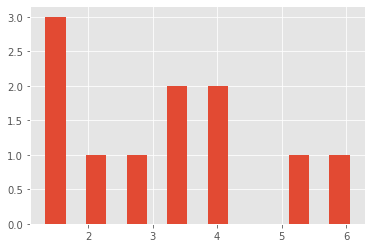

In [173]:
plt.hist(regression_data['ulev_market_share_%'],bins=15)

In [174]:
# first use the original independent variables

Y = regression_data['ulev_market_share_%']
X = regression_data.loc[:,list1]

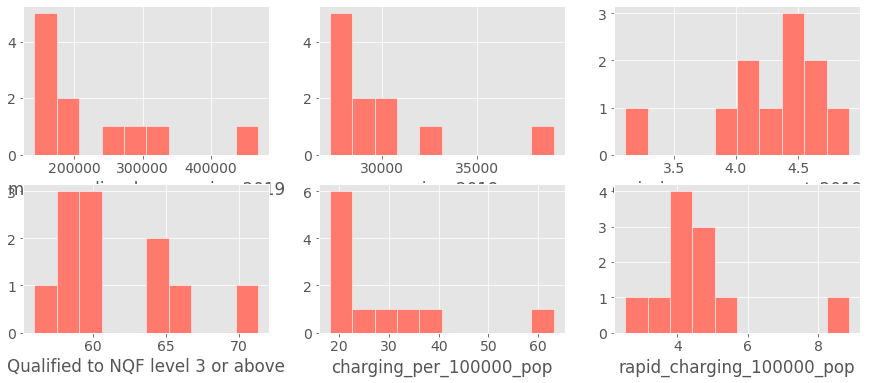

In [175]:
plt.rcParams.update({'font.size': 14})

fig2, axes2 = plt.subplots(2,3, figsize=(15,6))
#axes[1][2].set_visible(False)
#plt.style.use('_mpl-gallery')
#axes[1][0].set_position([0.24,0.125,0.228,0.343])
#axes[1][1].set_position([0.55,0.125,0.228,0.343])


#fig2.tight_layout(pad=5)

for i in range(2):
    for j in range(3):
        #if (i==1 and j==2):
            #continue
        axes2[i,j].hist(regression_data[list1[j+3*i]],bins=10,edgecolor="white",color='xkcd:salmon')
        #axes[i,j].set_title(list1[j+3*i])
        axes2[i,j].set(xlabel= list1[j+3*i])
        
#fig2.suptitle('Distribution of independent variables',fontsize=20)

<ipython-input-176-c1350dc2a60d>:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig3.tight_layout(pad=10)


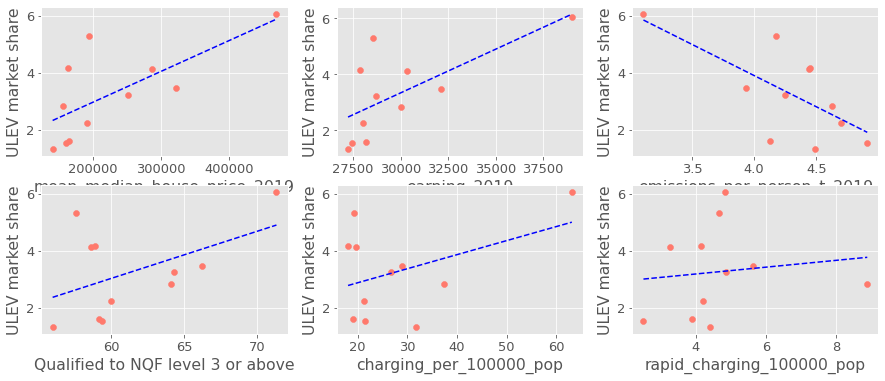

In [176]:
plt.rcParams.update({'font.size': 13})

fig3, axes3 = plt.subplots(2,3, figsize=(15,6))
#axes[1][2].set_visible(False)

#axes[1][0].set_position([0.24,0.125,0.228,0.343])
#axes[1][1].set_position([0.55,0.125,0.228,0.343])


fig3.tight_layout(pad=10)

for i in range(2):
    for j in range(3):
        #if (i==1 and j==2):
            #continue
        axes3[i,j].scatter(regression_data[list1[j+3*i]], regression_data['ulev_market_share_%'],color='xkcd:salmon')
        #axes[i,j].set_title(list1[j+3*i])
        axes3[i,j].plot(np.unique(regression_data[list1[j+3*i]]), np.poly1d(np.polyfit(regression_data[list1[j+3*i]], regression_data['ulev_market_share_%'], 1))(np.unique(regression_data[list1[j+3*i]])),color='blue',linestyle='dashed')
        axes3[i,j].set(xlabel= list1[j+3*i])
        axes3[i,j].set(ylabel= 'ULEV market share')
        
#fig3.suptitle('scatter plot',fontsize=20)

VIF 

Text(0.5, 1.0, 'Correlation Matrix')

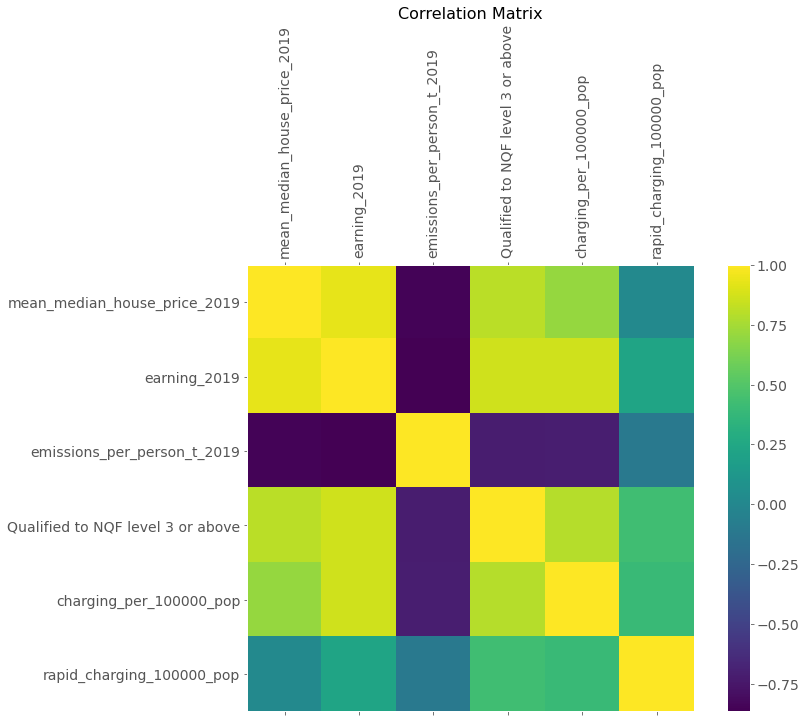

In [177]:


df = X
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [178]:

# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [179]:
X

,mean_median_house_price_2019,earning_2019,emissions_per_person_t_2019,Qualified to NQF level 3 or above,charging_per_100000_pop,rapid_charging_100000_pop
0,"141,000.0000",27234,4.4912,56.0000,31.7985,4.4020
1,"164,835.7500",28175,4.1238,59.2000,19.1113,3.9083
2,"163,362.5000",27879,4.4510,58.9000,18.0993,4.1609
3,"192,125.0000",28044,4.6993,60.0000,21.2782,4.2047
4,"193,748.7500",28549,4.1796,57.6000,19.2281,4.6604
5,"287,125.0000",30350,4.4398,58.6000,19.7079,3.2736
6,"470,000.0000",39013,3.1111,71.3000,63.0998,4.8271
7,"322,250.0000",32127,3.9379,66.2000,28.8558,5.6276
8,"251,499.8750",28721,4.2512,64.3000,26.7570,4.8574
9,"160,243.1250",27466,4.9088,59.4000,21.4090,2.5170


In [180]:
# do the VIF
X_dropped = drop_column_using_vif_(X)

Dropping: earning_2019
Dropping: mean_median_house_price_2019


F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0.5, 1.0, 'Correlation Matrix')

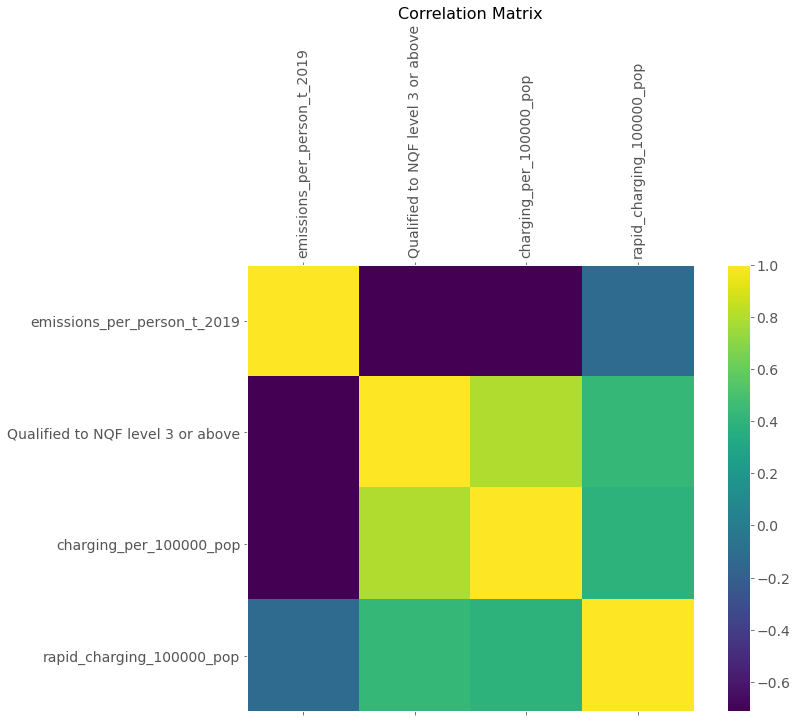

In [181]:
# now do the regression with VIF since the model_0's issue
# first do a correlation matrix for X

df = X_dropped
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [182]:
X1 = X_dropped
X1 = sm.add_constant(X1)

model_1=sm.OLS(Y,X1).fit()
model_1.summary()

F:\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ulev_market_share_%   R-squared:                       0.474
Model:                             OLS   Adj. R-squared:                  0.124
Method:                  Least Squares   F-statistic:                     1.353
Date:                 Tue, 18 Jan 2022   Prob (F-statistic):              0.352
Time:                         15:21:14   Log-Likelihood:                -16.401
No. Observations:                   11   AIC:                             42.80
Df Residuals:                        6   BIC:                             44.79
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                13.0954     14.830      0.883      0.411     -23.193      49.384
emissions_per_person_t_2019          -2.5173      1.555     -1.619      0.157      -6.322       1.288
Qualified to NQF level 3 or above     0.0203      0.189      0.108      0.918      -0.442       0.482
charging_per_100000_pop              -0.0258      0.063     -0.412      0.694      -0.179       0.127
rapid_charging_100000_pop             0.0960      0.337      0.285      0.786      -0.729       0.921
==============================================================================
Omnibus:                        0.566   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.409
Skew:                          -0.398   Prob(JB):                        0.815
Kurtosis:                       2.490   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

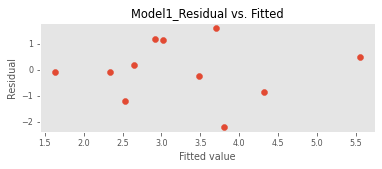

In [183]:
# for residual plot 
plt.figure(figsize=(6,2))
plt.rcParams.update({'font.size': 8})
plt.scatter(model_1.fittedvalues, model_1.resid)
# adding title and labels
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Model1_Residual vs. Fitted')
plt.show()



remove two variables with large P-values and do regression Model_2

In [184]:
X2 = regression_data[['emissions_per_person_t_2019','charging_per_100000_pop']]
X2 = sm.add_constant(X2)

model_2=sm.OLS(Y,X2).fit()
model_2.summary()

F:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
F:\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ulev_market_share_%   R-squared:                       0.463
Model:                             OLS   Adj. R-squared:                  0.329
Method:                  Least Squares   F-statistic:                     3.453
Date:                 Tue, 18 Jan 2022   Prob (F-statistic):             0.0830
Time:                         15:21:14   Log-Likelihood:                -16.515
No. Observations:                   11   AIC:                             39.03
Df Residuals:                        8   BIC:                             40.22
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          14.2409      6.031      2.361      0.046       0.334      28.148
emissions_per_person_t_2019    -2.4640      1.189     -2.072      0.072      -5.206       0.278
charging_per_100000_pop        -0.0142      0.043     -0.329      0.751      -0.114       0.085
==============================================================================
Omnibus:                        0.697   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.706   Jarque-Bera (JB):                0.483
Skew:                          -0.445   Prob(JB):                        0.785
Kurtosis:                       2.489   Cond. No.                         494.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

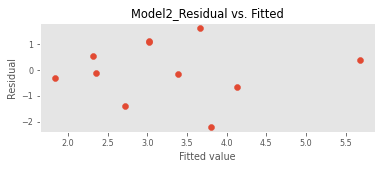

In [185]:
# for residual plot 
plt.figure(figsize=(6,2))
plt.rcParams.update({'font.size': 8})
plt.scatter(model_2.fittedvalues, model_2.resid)
# adding title and labels
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Model2_Residual vs. Fitted')
plt.show()

